In [161]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
Normal = tf.distributions.Normal
Bernoulli = tf.distributions.Bernoulli

### Utility functions

In [4]:
def permute(X, y=None):
    n_all_cases = X.shape[0]
    perm = np.arange(n_all_cases)
    np.random.shuffle(perm)
    if y is not None:
        return X[perm], y[perm]
    else:
        return X[perm], None

In [5]:
def plot_latent_space(model, onehot_encoder, X, y):
    m, sd = model.encode2(X)
    m_flat = m.reshape(-1)
    sd_flat = sd.reshape(-1)
    y_decoded = onehot_encoder.inverse_transform(y).reshape(-1)
    plt.figure(figsize=(10, 10))
    plt.scatter(m_flat, sd_flat, c=y_decoded, cmap='brg')
    plt.colorbar()
    plt.show()

In [235]:
def plot_2d_latent_space(model, onehot_encoder, X, y):
    m, sd = model_supervised.encode2(X_test)
    y_decoded = onehot_encoder.inverse_transform(y_test).reshape(-1)
    fig = plt.figure(figsize=(20, 20))


    plt.subplot(2, 2, 1)
    plt.scatter(m[:,0], m[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 2)
    plt.scatter(sd[:,0], sd[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.subplot(2, 2, 3)
    plt.scatter(m[:,0], sd[:,0], c=y_decoded, cmap='brg')
    plt.colorbar()

    Z = np.random.normal(m,1)
    plt.subplot(2, 2, 4)
    plt.scatter(Z[:,0], Z[:,1], c=y_decoded, cmap='brg')
    plt.colorbar()

    plt.show()

### Import MNIST

In [7]:
mnist = tf.keras.datasets.mnist

### Load data

In [8]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [9]:
y_train.shape

(60000,)

In [10]:
X = np.concatenate((X_train, X_test), axis=0)

In [11]:
n_all_cases = X.shape[0]
input_dim = X.shape[1]

In [12]:
X = np.reshape(X, (n_all_cases, -1))
y = np.concatenate((y_train, y_test)).astype('float32')

In [13]:
label_reshaped = y.reshape(len(y), 1)
onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
onehot_encoded = onehot_encoder.fit_transform(label_reshaped)

In [14]:
n_classes = onehot_encoded.shape[1]

In [15]:
X = (X > 0.5).astype(np.float32)

In [16]:
X_perm, onehot_encoded_perm = permute(X,onehot_encoded)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_perm, onehot_encoded_perm, test_size=0.1, random_state=40)

In [18]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
y_test.shape

(7000, 10)

### Utility functions

In [20]:
def get_log_folder():
    now = datetime.datetime.now()
    day_of_the_year=now.strftime("%d_%m_%Y")
    suff = now.strftime("%Y%m%d%H%M%S")
    #print(now.strftime("%Y%m%d%H%M%S"))
    log_folder = "/tmp/class_vae/deep/{}/{}".format(day_of_the_year,suff)
    return log_folder

In [128]:
def calculate_accuracy_np(y_pred, y_true):
    predicted_class = np.argmax(y_pred, axis=1)
    true_class = np.argmax(y_true, axis=1)
    cond_correct = predicted_class == true_class
    return np.mean(cond_correct.astype(int))

In [129]:
def accuracy_for_score(y_pred, y_true, score, threshold):
    cond = score > threshold
    accuracy = calculate_accuracy_np(y_pred[cond], y_true[cond])
    return accuracy

In [130]:
def classification_ratio(score, threshold):
    cond = score > threshold
    above_threshold = np.mean((score > threshold).astype(int))
    return above_threshold

### Build neural network

In [21]:
class DenseLayer:

    def __init__(self, in_dim, out_dim, f=tf.nn.relu, name="dense"):
        self.name = name
        with tf.name_scope(self.name):
            self.f = f
            initializer = tf.contrib.layers.xavier_initializer()
            self.W = tf.Variable(initializer((in_dim, out_dim)), name="W")
            self.b = tf.Variable(tf.constant(0.1, shape=[out_dim]), name="bias")
            tf.summary.histogram("weights", self.W)
            tf.summary.histogram("bias", self.b)

    def forward(self, X):
        with tf.name_scope(self.name):
            act = self.f(tf.matmul(X, self.W) + self.b)
            tf.summary.histogram("activation", act)
            return act

In [252]:
class VClassifier:

    def encode(self, X, middle_layer_dim):
        current_value = X
        for layer in self.encoder_layers:
            current_value = layer.forward(current_value)

        means = current_value[:, :middle_layer_dim]
        tmp = current_value[:, middle_layer_dim:]
#         stdevs = tf.sqrt(tf.exp(tmp))
        stdevs = tf.nn.softplus(tmp) + 1e-6
        
        
        return means, stdevs
    
    def create_encoder(self, X, input_dim, hidden_dims):
        
        in_dim = input_dim
        for h_dim in hidden_dims[:-1]:
            h = DenseLayer(in_dim, h_dim)
            self.encoder_layers.append(h)
            in_dim = h_dim

        middle_layer_dim = hidden_dims[-1]
        self.encoder_layers.append(DenseLayer(in_dim, 2 * middle_layer_dim, f=lambda x: x))

        return self.encode(X, middle_layer_dim)
    
    def decode(self, Z, output_dim, hidden_dims):
        decoder_layers = []

        in_dim = hidden_dims[-1]
        for hidden_dim in reversed(hidden_dims[:-1]):
            h = DenseLayer(in_dim, hidden_dim)
            decoder_layers.append(h)
            in_dim = hidden_dim

        decoder_layers.append(DenseLayer(in_dim, output_dim, f=lambda x: x))

        current_value = Z
        for decoder_layer in decoder_layers:
            current_value = decoder_layer.forward(current_value)

        return current_value
    
    def calculateKL(self, mean, std):
        inner = 1 + tf.math.log(1e-8 + std ** 2) - mean ** 2 - std ** 2
        kls = 0.5 * tf.math.reduce_sum(inner, axis=1)
        return tf.math.reduce_mean(kls)
    
    def create_accuracy_node(self, y_true, y_pred):
        correct_mask_node = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
        accuracy_node = tf.reduce_mean(tf.cast(correct_mask_node, tf.float32))
        return accuracy_node

    def __init__(self, x_dim, y_dim, hidden_dims, log_folder, alpha, beta, gamma):
        self.encoder_layers = []
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.layer = 1
        
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, shape=(None, x_dim), name="x")
        self.y = tf.placeholder(tf.float32, shape=(None, y_dim), name="y")

        #encoder
        self.means, self.stdevs = self.create_encoder(self.X, x_dim, hidden_dims)

        n = Normal(
          loc=self.means,
          scale=self.stdevs,
        )
        Z = n.sample()
        
#         n_z = hidden_dims[-1]
#         eps = tf.random_normal(shape=tf.shape(self.means), mean=0, stddev=1, 
#                                dtype=tf.float32)
#         # z = mu + sigma*epsilon
#         Z = tf.add(self.means, self.stdevs * eps)
        
        print("Hidden shape: {}".format(Z.shape))

        #decoder
        self.logits = self.decode(Z, (x_dim+y_dim), hidden_dims)

        self.XY_hat_distribution = Bernoulli(logits=self.logits)
        #self.posterior_predictive = self.Y_hat_distribution.sample()

        #with tf.name_scope('sample_output_reshaped'):
        #    posterior_predictive_reshaped = tf.reshape(self.posterior_predictive, [-1, 28, 28, 1])
        #    tf.summary.image('sample_output', tf.cast(posterior_predictive_reshaped, tf.float32), 10)

        self.posterior_predictive_probs = tf.nn.sigmoid(self.logits)
        self.score = tf.norm(self.means, axis=1)
        
        if y_dim > 0:
            self.posterior_predictive_probs_y = self.posterior_predictive_probs[:,x_dim:(x_dim+y_dim)]
            print("self.posterior_predictive_probs_y.shape {}".format(self.posterior_predictive_probs_y.get_shape().as_list()))
            print("self.y.shape {}".format(self.y.get_shape().as_list()))
            self.accuracy_node = self.create_accuracy_node(self.y, self.posterior_predictive_probs_y)
            tf.summary.scalar("accuracy", self.accuracy_node)

        # with tf.name_scope('probs_output_reshaped'):
        #     posterior_predictive_probs_reshaped = tf.reshape(self.posterior_predictive_probs[:,0:x_dim], [-1, 28, 28, 1])
        #     tf.summary.image('probs_output', posterior_predictive_probs_reshaped, 10)

        with tf.name_scope('COST'):
            
            if y_dim > 0:
                xy = tf.concat([self.X, self.y], axis=1)
            else:
                xy = self.X
            print("xy.shape {}".format(xy.get_shape().as_list()))
#             expected_log_likelihood = tf.reduce_sum(
#                 self.XY_hat_distribution.log_prob(xy),
#                 axis=1
#             )
            
            #tf.exp(tf.reduce_sum(y_true*tf.log(1e-10+y_pred) + (1-y_true)*tf.log(1e-10+1-y_pred)))
            expected_log_likelihood_2 = -tf.reduce_sum(
                tf.nn.sigmoid_cross_entropy_with_logits(labels=self.X, logits=self.logits[:,0:x_dim]), 
                axis=1
            )
            
#             expected_log_likelihood_2 = tf.reduce_sum(
#                 cross_entropy,
#                 axis=1
#             )
            
            #tf.summary.scalar("Expected log-likelihood", tf.reduce_sum(expected_log_likelihood))

            kl = self.calculateKL(self.means, self.stdevs)
            tf.summary.scalar("KL", kl)

#             exp_loglik = tf.reduce_mean(expected_log_likelihood)
#             tf.summary.scalar("loglik", exp_loglik)
            
            exp_loglik_2 = tf.reduce_mean(expected_log_likelihood_2)
            tf.summary.scalar("loglik_2", exp_loglik_2)
            
            if y_dim > 0:
                cross_entropy_classifier = tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.y, logits=self.logits[:,x_dim:(x_dim+y_dim)])
                avg_cross_entropy_classifier = -tf.reduce_mean(cross_entropy_classifier)
                tf.summary.scalar("softmax_cross_entropy", avg_cross_entropy_classifier)
                elbo = alpha * exp_loglik_2 + beta * kl + gamma * avg_cross_entropy_classifier
            else:
                elbo = alpha * exp_loglik_2 + beta * kl
                
            tf.summary.scalar("ELBO", elbo)


            
        self.train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(-elbo)
        #self.train_op = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(-elbo)

        self.init_op = tf.global_variables_initializer()
            
        #InteractiveSession.close()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)

        self.merged_summary = tf.summary.merge_all()

        self.writer_train = tf.summary.FileWriter(log_folder)
        self.writer_train.add_graph(self.sess.graph)

    def fit(self, X_train, y_train, epochs=30, batch_sz=64):
        #costs=[]
        n_batches = len(X_train) // batch_sz
        print("n_batches:", n_batches)

        iter = 1
        for i in range(epochs):
            print("epoch: %d" % i)
            #np.random.shuffle(X_train)
            X_train, y_train = permute(X_train, y_train)
            for j in range(n_batches):
                batch_x = X_train[j * batch_sz:(j + 1) * batch_sz]
                
                if self.y_dim > 0:
                    batch_y = y_train[j * batch_sz:(j + 1) * batch_sz]
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x, self.y: batch_y})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x, self.y: batch_y})
                        self.writer_train.add_summary(s, iter)
                else:
                    self.sess.run(self.train_op, feed_dict={self.X: batch_x})
                    if j % 100 == 0:
                        s = self.sess.run(self.merged_summary, feed_dict={self.X: batch_x})
                        self.writer_train.add_summary(s, iter)
                    
                iter += 1
            
            if self.y_dim > 0:
                train_accuracy = self.calculate_accuracy(X_train, y_train)
                print("Train accuracy {}".format(train_accuracy))

        # plt.plot(costs)
        # plt.show()
        
    def calculate_accuracy(self, X, y):
        accuracy = self.sess.run(self.accuracy_node, feed_dict={self.X: X, self.y: y})
        return accuracy
        
    def predict(self, X):
        y_pred = self.sess.run([self.posterior_predictive_probs_y, self.score], feed_dict={self.X: X})
        return y_pred

#     def predict_probs(self, X):
#         return self.sess.run(self.posterior_predictive_probs, feed_dict={self.X: X})
    
    def encode2(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        return means, stdevs
    
    def sampleLatent(self, X):
        means, stdevs = self.sess.run([self.means, self.stdevs], feed_dict={self.X: X})
        n = Normal(
          loc=means,
          scale=stdevs,
        )
        Z = n.sample()
        return Z

In [253]:
def analyse_model_wrt_2d_plot(alpha, beta, gamma, epochs=10):
    log_folder = get_log_folder()
    print('Starting autoencoder. Log folder={}'.format(log_folder))
    X_train, X_test, y_train, y_test
    model_supervised = VClassifier(
        x_dim=X_train.shape[1], 
        y_dim=y_train.shape[1], 
        hidden_dims=[512, 256, 128, 2], 
        log_folder=log_folder,
        alpha=alpha,
        beta=beta,
        gamma=gamma
    )
    model_supervised.fit(X_train, y_train, epochs=epochs)

    test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
    print("Test accuracy {}".format(test_acc))
    plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)
    plot_2d_latent_space(model_supervised, onehot_encoder, X_train, y_train)

### Supervised VAE

In [259]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=0.1,
    beta=1,
    gamma=10
)
model_supervised.fit(X_train, y_train, epochs=3)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/05_04_2019/20190405180512
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9113016128540039
epoch: 1
Train accuracy 0.9450317621231079
epoch: 2
Train accuracy 0.9403492212295532
Test accuracy 0.9297142624855042


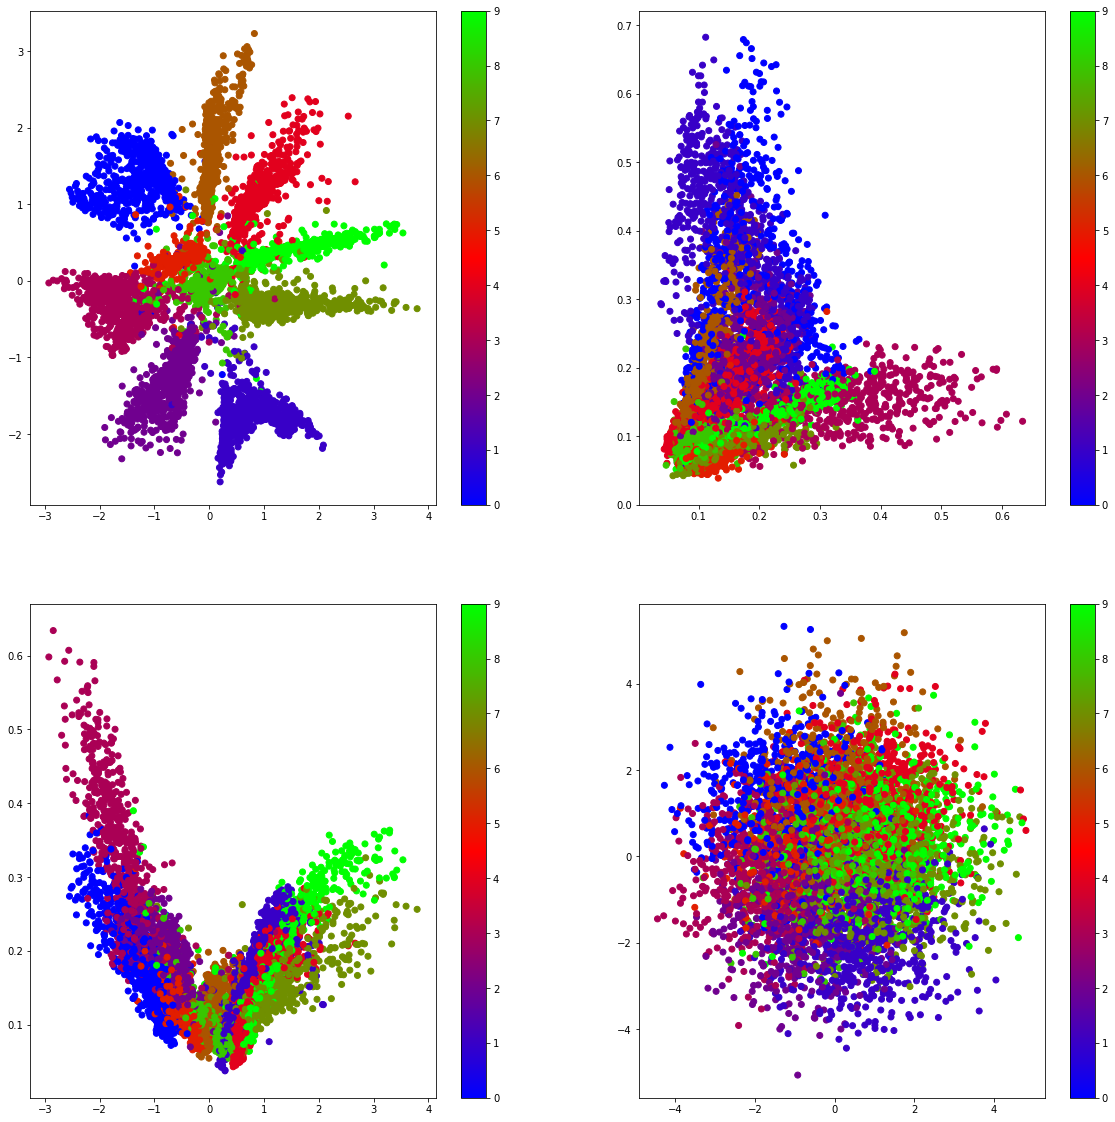

In [260]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

In [261]:
prediction, score_arr = model_supervised.predict(X_test)

In [197]:
np.mean((score_arr > 10.0).astype(int))

0.8297142857142857

In [198]:
max_score = np.max(score_arr)
max_score

139.97134

In [199]:
x_plot = np.linspace(0,max_score,100)

In [200]:
accuracy_plot = [accuracy_for_score(prediction, y_test, score_arr, s) for s in x_plot]
class_ratio = [classification_ratio(score_arr, s) for s in x_plot]

/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


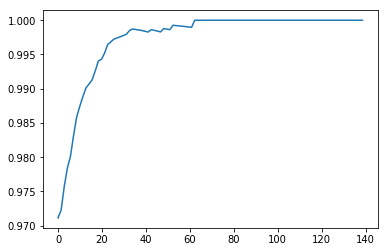

In [201]:
plt.plot(x_plot, accuracy_plot)

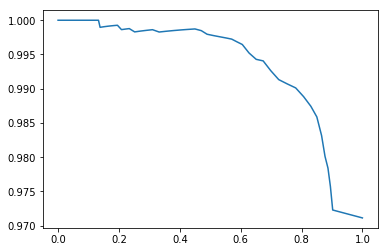

In [202]:
plt.plot(class_ratio, accuracy_plot)

In [203]:
train_prediction, train_score_arr = model_supervised.predict(X_train)

In [217]:
# accuracy below 0.99
low_accuracy = train_score_arr < 9.133511

In [218]:
len(train_score_arr[low_accuracy])

9674

(array([6.248e+03, 4.320e+02, 5.560e+02, 7.350e+02, 1.044e+03, 1.293e+03,
        1.752e+03, 1.898e+03, 1.993e+03, 1.876e+03, 1.804e+03, 1.699e+03,
        1.698e+03, 1.505e+03, 1.382e+03, 1.313e+03, 1.444e+03, 1.400e+03,
        1.458e+03, 1.491e+03, 1.612e+03, 1.662e+03, 1.659e+03, 1.697e+03,
        1.759e+03, 1.660e+03, 1.546e+03, 1.446e+03, 1.329e+03, 1.137e+03,
        1.046e+03, 8.790e+02, 7.880e+02, 7.220e+02, 6.560e+02, 5.560e+02,
        4.740e+02, 4.530e+02, 4.230e+02, 4.020e+02, 3.730e+02, 4.130e+02,
        3.600e+02, 3.200e+02, 3.480e+02, 3.030e+02, 3.360e+02, 3.500e+02,
        3.050e+02, 2.860e+02, 2.750e+02, 2.830e+02, 3.220e+02, 2.750e+02,
        2.460e+02, 2.490e+02, 2.480e+02, 2.120e+02, 2.200e+02, 1.850e+02,
        2.010e+02, 1.970e+02, 1.990e+02, 1.490e+02, 1.610e+02, 1.510e+02,
        1.350e+02, 1.120e+02, 1.120e+02, 1.110e+02, 8.000e+01, 9.600e+01,
        7.100e+01, 7.300e+01, 5.700e+01, 5.900e+01, 4.500e+01, 2.500e+01,
        2.400e+01, 2.800e+01, 1.900e+0

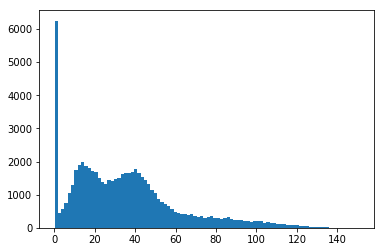

In [219]:
plt.hist(train_score_arr, bins='auto')

In [220]:
train_x_plot = np.linspace(0,np.max(train_score_arr),100)

In [221]:
train_accuracy_plot = [accuracy_for_score(train_prediction, y_train, train_score_arr, s) for s in train_x_plot]
train_class_ratio = [classification_ratio(train_score_arr, s) for s in train_x_plot]

/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [222]:
pd.DataFrame(
    {'accuracy': train_accuracy_plot,
     'threshold': train_x_plot
    })[0:50]

,accuracy,threshold
0,0.979349,0.000000
1,0.981104,1.522252
2,0.983937,3.044504
3,0.986458,4.566755
4,0.988529,6.089007
5,0.989985,7.611259
6,0.991318,9.133511
7,0.992653,10.655762
8,0.993983,12.178014
9,0.994959,13.700266


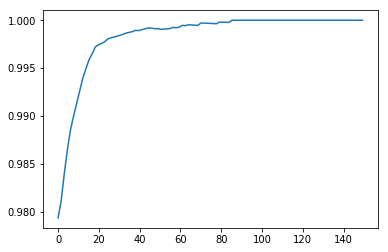

In [223]:
plt.plot(train_x_plot, train_accuracy_plot)

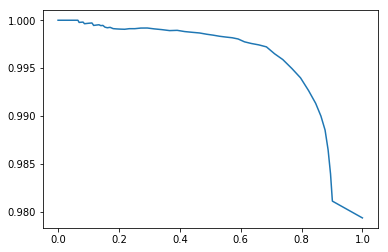

In [224]:
plt.plot(train_class_ratio, train_accuracy_plot)

In [225]:
train_accuracy_plot_np = np.array(train_accuracy_plot)
ind = np.argmax(train_accuracy_plot_np >= 1.0)
train_x_plot[ind]

/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater_equal
  


85.2460999151673

In [226]:
accuracy_for_score(train_prediction, y_train, train_score_arr, 41.181172688802086)

0.9990171760190949

In [227]:
X_train_low = X_train[low_accuracy]
y_train_low = y_train[low_accuracy]

In [228]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised_2 = VClassifier(
    x_dim=X_train_low.shape[1], 
    y_dim=y_train_low.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=0,
    beta=0,
    gamma=1
)
model_supervised_2.fit(X_train_low, y_train_low, epochs=30)

test_acc = model_supervised_2.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/30_03_2019/20190330234945
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 151
epoch: 0
Train accuracy 0.809489369392395
epoch: 1
Train accuracy 0.8509406447410583
epoch: 2
Train accuracy 0.8798842430114746
epoch: 3
Train accuracy 0.887223482131958
epoch: 4
Train accuracy 0.894045889377594
epoch: 5
Train accuracy 0.9077940583229065
epoch: 6
Train accuracy 0.9241265058517456
epoch: 7
Train accuracy 0.9152367115020752
epoch: 8
Train accuracy 0.9459375739097595
epoch: 9
Train accuracy 0.9356005787849426
epoch: 10
Train accuracy 0.9500723481178284
epoch: 11
Train accuracy 0.9426297545433044
epoch: 12
Train accuracy 0.9549307227134705
epoch: 13
Train accuracy 0.9684721827507019
epoch: 14
Train accuracy 0.972710371017456
epoch: 15
Train accuracy 0.9636138081550598
epoch: 16
Train accuracy 0.9701260924339294
epoch: 17
Train accuracy 0.9695059061050415
epoch: 18
Train accuracy 0.971159815788269
epoch: 19
Train accuracy 0.9834608435630798
epoch: 20
Train accuracy 0.9671283960342407
epoch: 21
Train accuracy 0.9802563786506653
epoch: 22
Train accuracy 0.98707

In [229]:
test_prediction, test_score_arr = model_supervised.predict(X_test)

In [230]:
cond_test_above = test_score_arr > 9.133511
cond_test_below = test_score_arr < 9.133511

In [231]:
X_test[cond_test_above]
test_acc = model_supervised.calculate_accuracy(X=X_test[cond_test_above], y=y_test[cond_test_above])
test_acc

0.98642457

In [232]:
test_acc2 = model_supervised_2.calculate_accuracy(X=X_test[cond_test_below], y=y_test[cond_test_below])
test_acc2

0.89250225

In [233]:
test_acc3 = model_supervised.calculate_accuracy(X=X_test[cond_test_below], y=y_test[cond_test_below])
test_acc3

0.8906956

In [ ]:
def get_threshold_for_accuracy(accuracies, thresholds):
    ind = np.argmax(train_accuracy_plot_np >= 1.0)

In [241]:
Z.shape

(7000, 2)

In [239]:
latent_with_labels = y_decoded.copy().reshape((len(y_decoded),1))
latent_with_labels.shape

(7000, 1)

In [244]:
np.concatenate((Z,latent_with_labels), axis=1)

array([[ 35.70706056, -12.77721555,   0.        ],
       [-38.19173873,   6.68964219,   2.        ],
       [ 14.85674631,   5.05486864,   8.        ],
       ...,
       [ 14.94978249,  16.91034773,   9.        ],
       [ 11.73894676,  14.66484492,   9.        ],
       [ 19.01328626,   7.24251662,   8.        ]])

In [232]:
Z

array([[  0.        , -11.45616943],
       [  2.        ,   8.10408531],
       [  8.        ,   4.71020641],
       ...,
       [  9.        ,  17.50588107],
       [  9.        ,  14.62329845],
       [  8.        ,   6.65451481]])

In [218]:
np.square(sd) * np.eye(sd.shape[1])

ValueError: operands could not be broadcast together with shapes (7000,2) (2,2) 

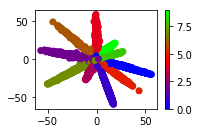

In [187]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
X_train, X_test, y_train, y_test
model_supervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=y_train.shape[1], 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=0,
    beta=1,
    gamma=100
)
model_supervised.fit(X_train, y_train, epochs=10)

test_acc = model_supervised.calculate_accuracy(X=X_test, y=y_test)
print("Test accuracy {}".format(test_acc))

Starting autoencoder. Log folder=/tmp/class_vae/deep/16_03_2019/20190316175605
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.935015857219696
epoch: 1
Train accuracy 0.9575873017311096
epoch: 2
Train accuracy 0.968666672706604
epoch: 3
Train accuracy 0.9679365158081055
epoch: 4
Train accuracy 0.9723174571990967
epoch: 5
Train accuracy 0.9748095273971558
epoch: 6
Train accuracy 0.9758729934692383
epoch: 7
Train accuracy 0.9810952544212341
epoch: 8
Train accuracy 0.9790475964546204
epoch: 9
Train accuracy 0.9832063317298889
Test accuracy 0.9685714244842529


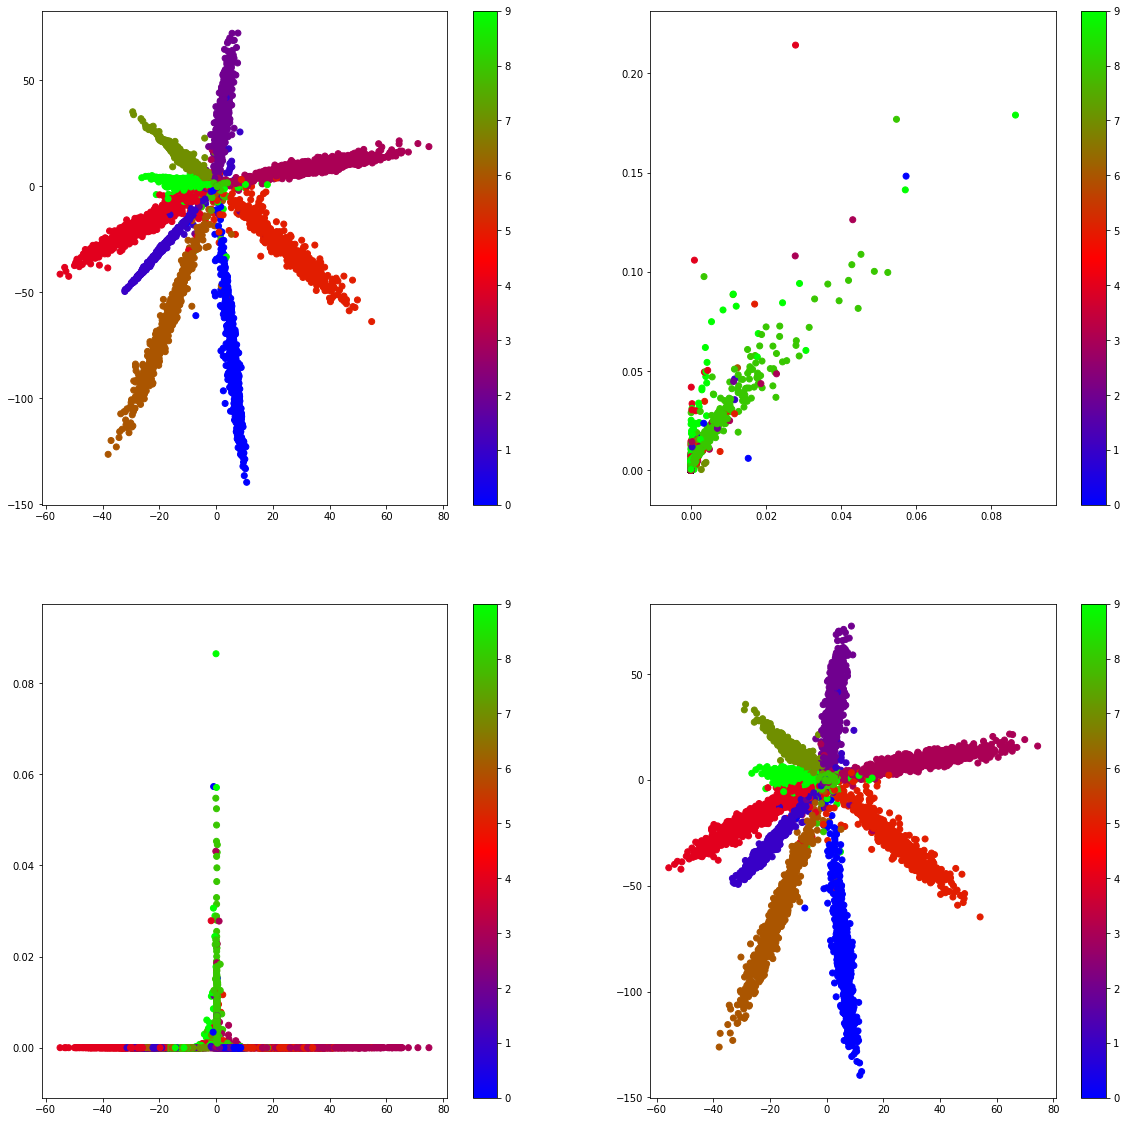

In [237]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_test, y_test)

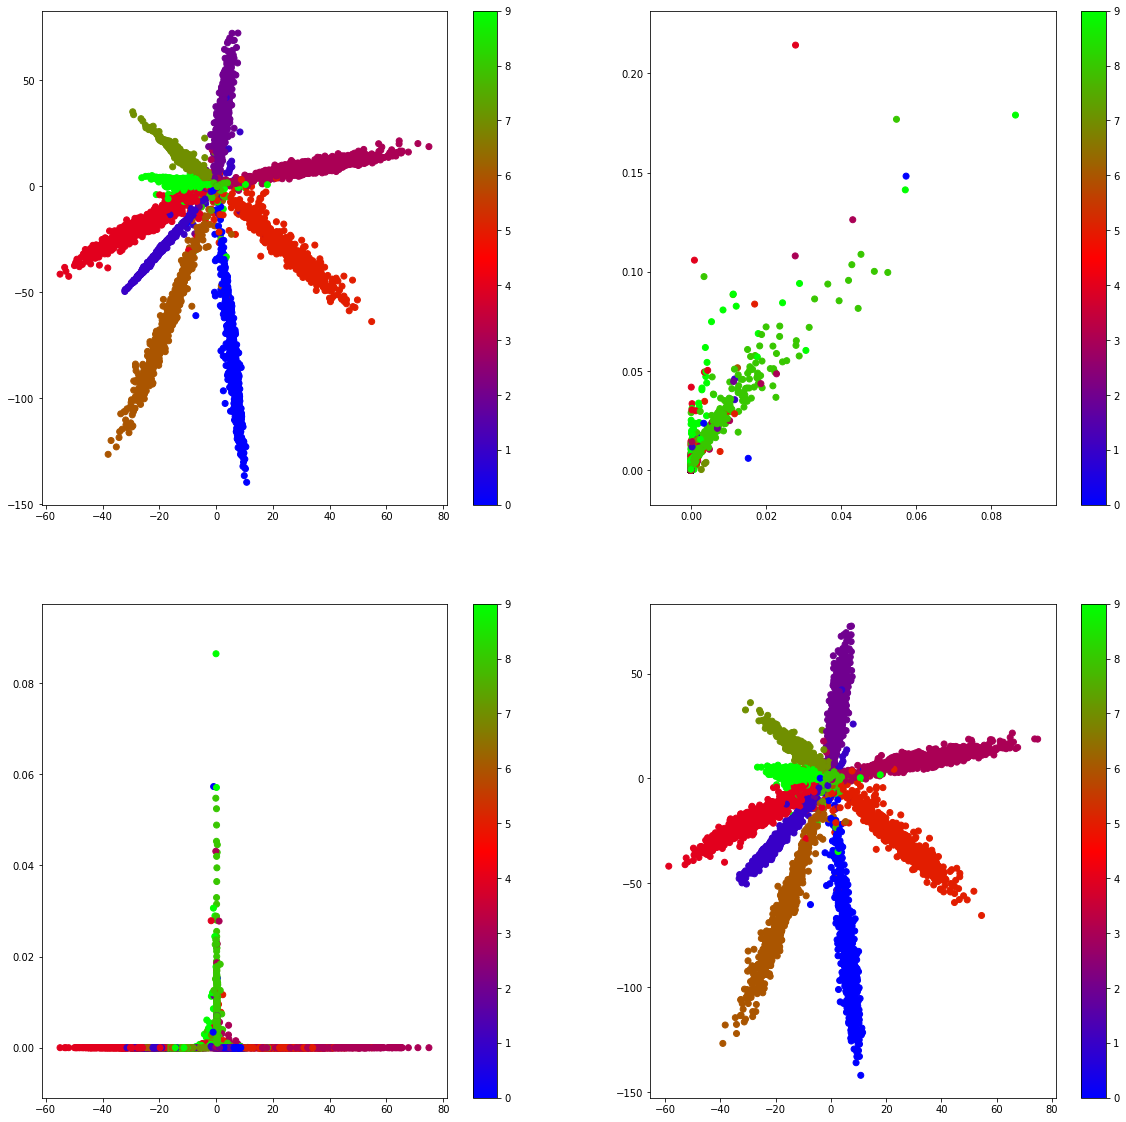

In [238]:
plot_2d_latent_space(model_supervised, onehot_encoder, X_train, y_train)

Starting autoencoder. Log folder=/tmp/class_vae/deep/16_03_2019/20190316180004
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.9349841475486755
epoch: 1
Train accuracy 0.9452381134033203
epoch: 2
Train accuracy 0.9608253836631775
epoch: 3
Train accuracy 0.9678888916969299
epoch: 4
Train accuracy 0.9703651070594788
epoch: 5
Train accuracy 0.9718254208564758
epoch: 6
Train accuracy 0.9749682545661926
epoch: 7
Train accuracy 0.9819047451019287
epoch: 8
Train accuracy 0.9816190600395203
epoch: 9
Train accuracy 0.9792698621749878
Test accuracy 0.9625714421272278


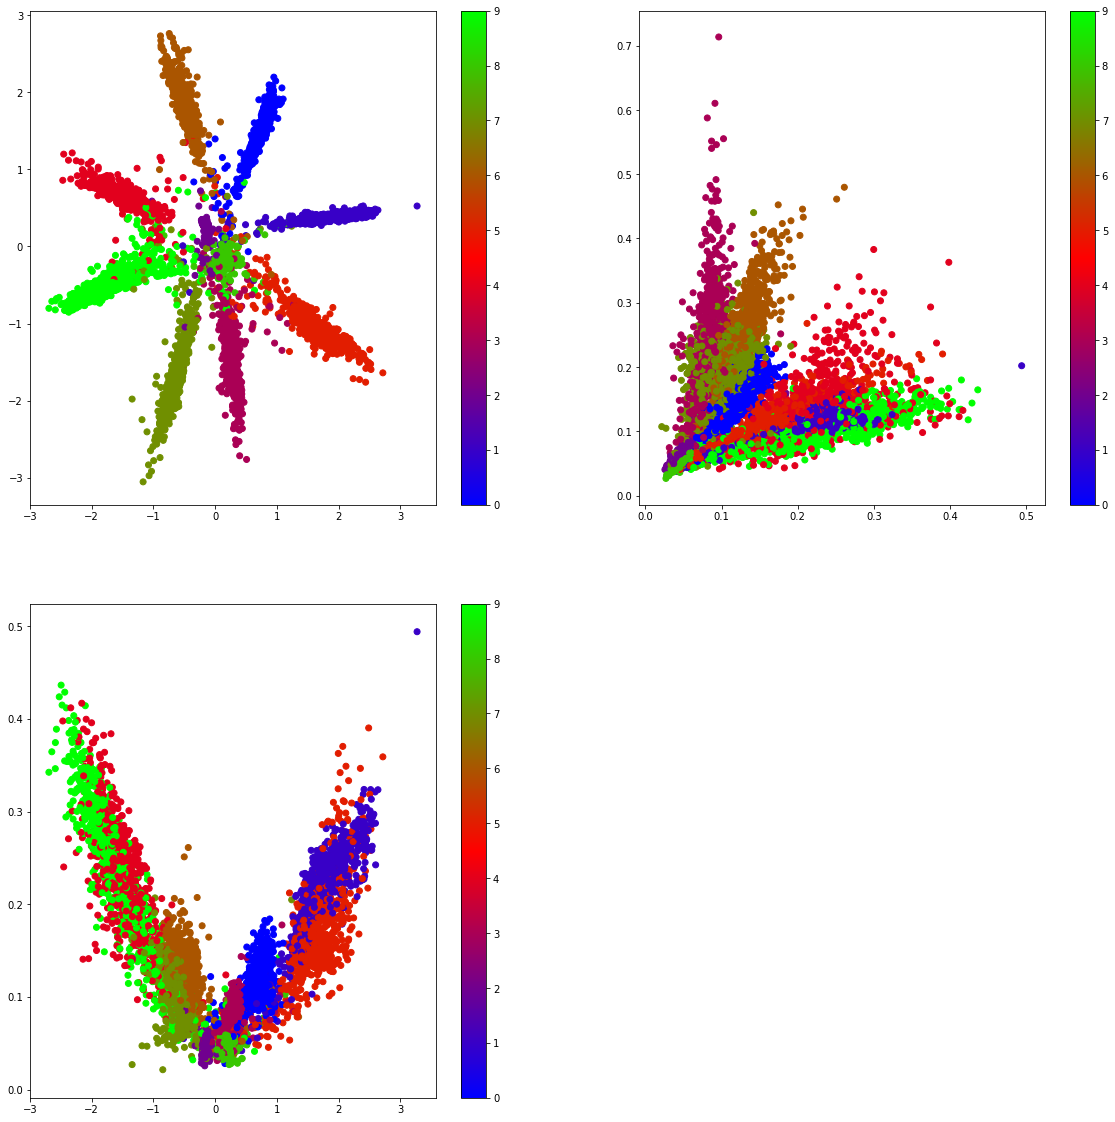

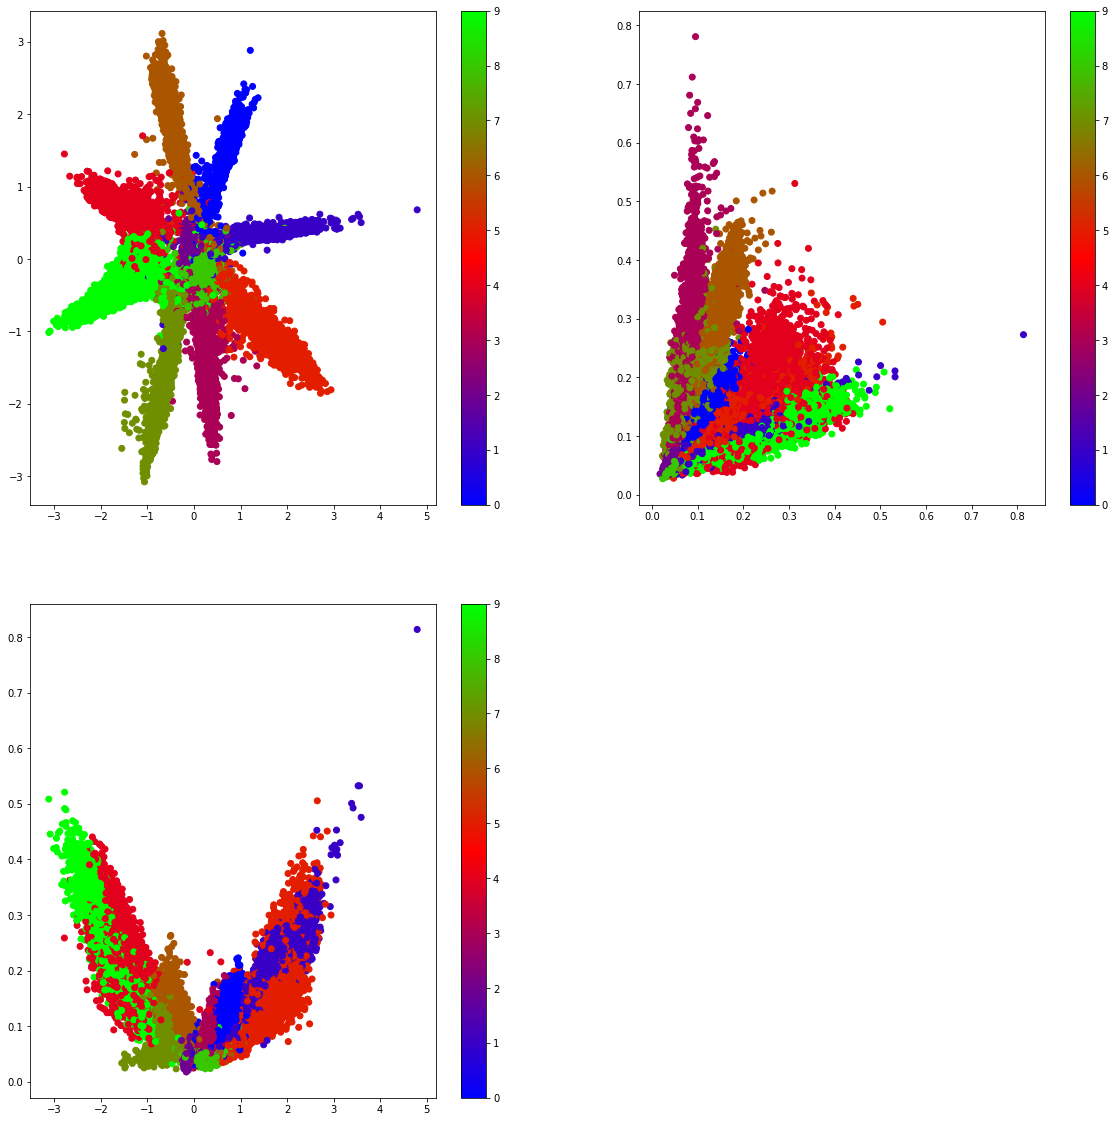

In [191]:
analyse_model_wrt_2d_plot(alpha=0, beta=1, gamma=50, epochs=10)

Starting autoencoder. Log folder=/tmp/class_vae/deep/16_03_2019/20190316181323
Hidden shape: (?, 2)
self.posterior_predictive_probs_y.shape [None, 10]
self.y.shape [None, 10]
xy.shape [None, 794]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
Train accuracy 0.10488888621330261
epoch: 1
Train accuracy 0.13771428167819977
epoch: 2
Train accuracy 0.08785714209079742
epoch: 3
Train accuracy 0.09734920412302017
epoch: 4
Train accuracy 0.10698412358760834
epoch: 5
Train accuracy 0.12076190114021301
epoch: 6
Train accuracy 0.11247619241476059
epoch: 7
Train accuracy 0.10984127223491669
epoch: 8
Train accuracy 0.11028571426868439
epoch: 9
Train accuracy 0.10985714197158813
Test accuracy 0.10814286023378372


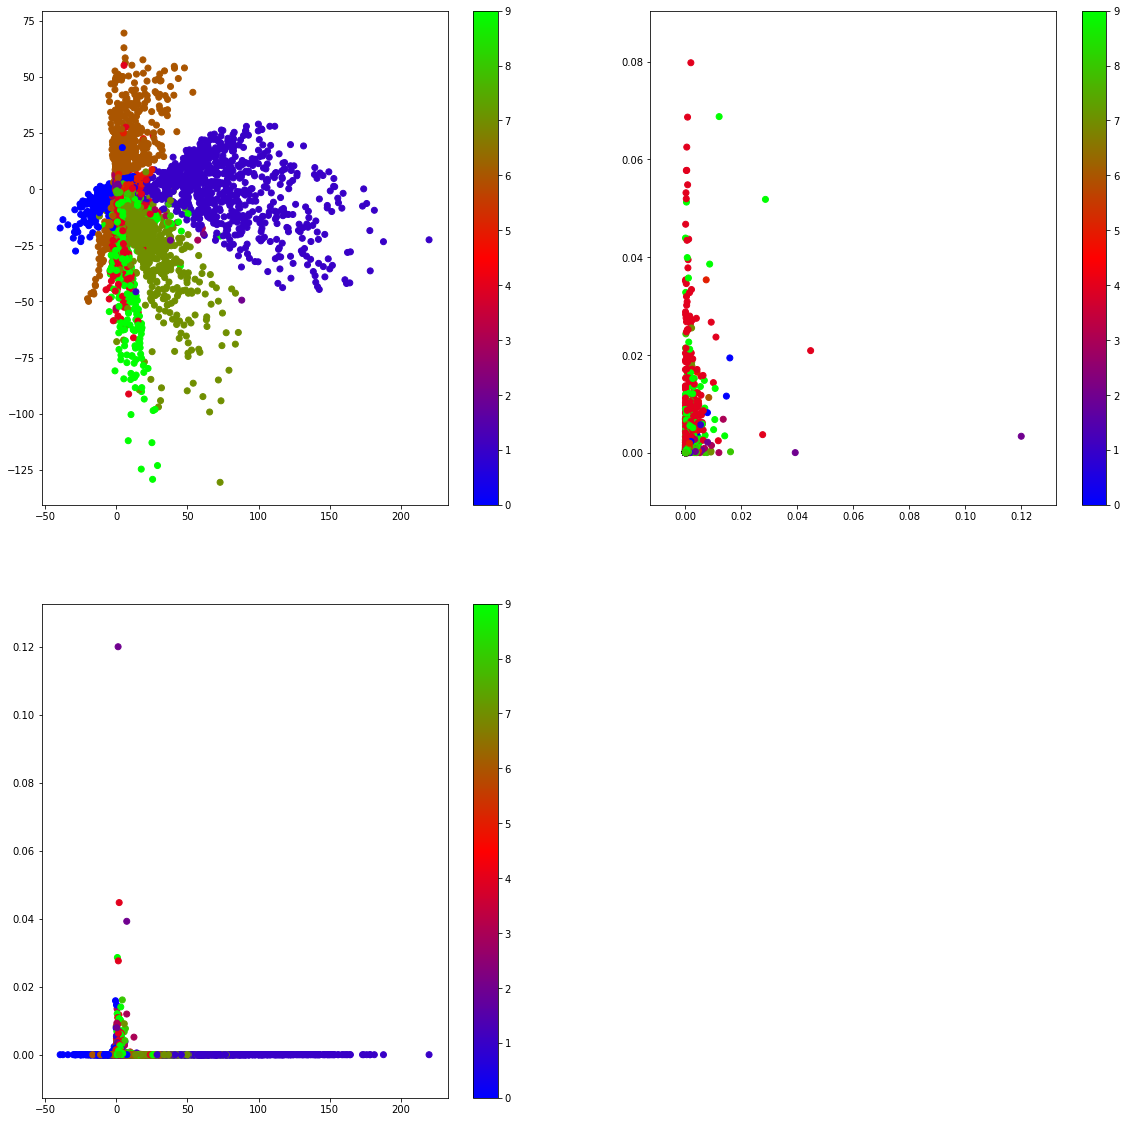

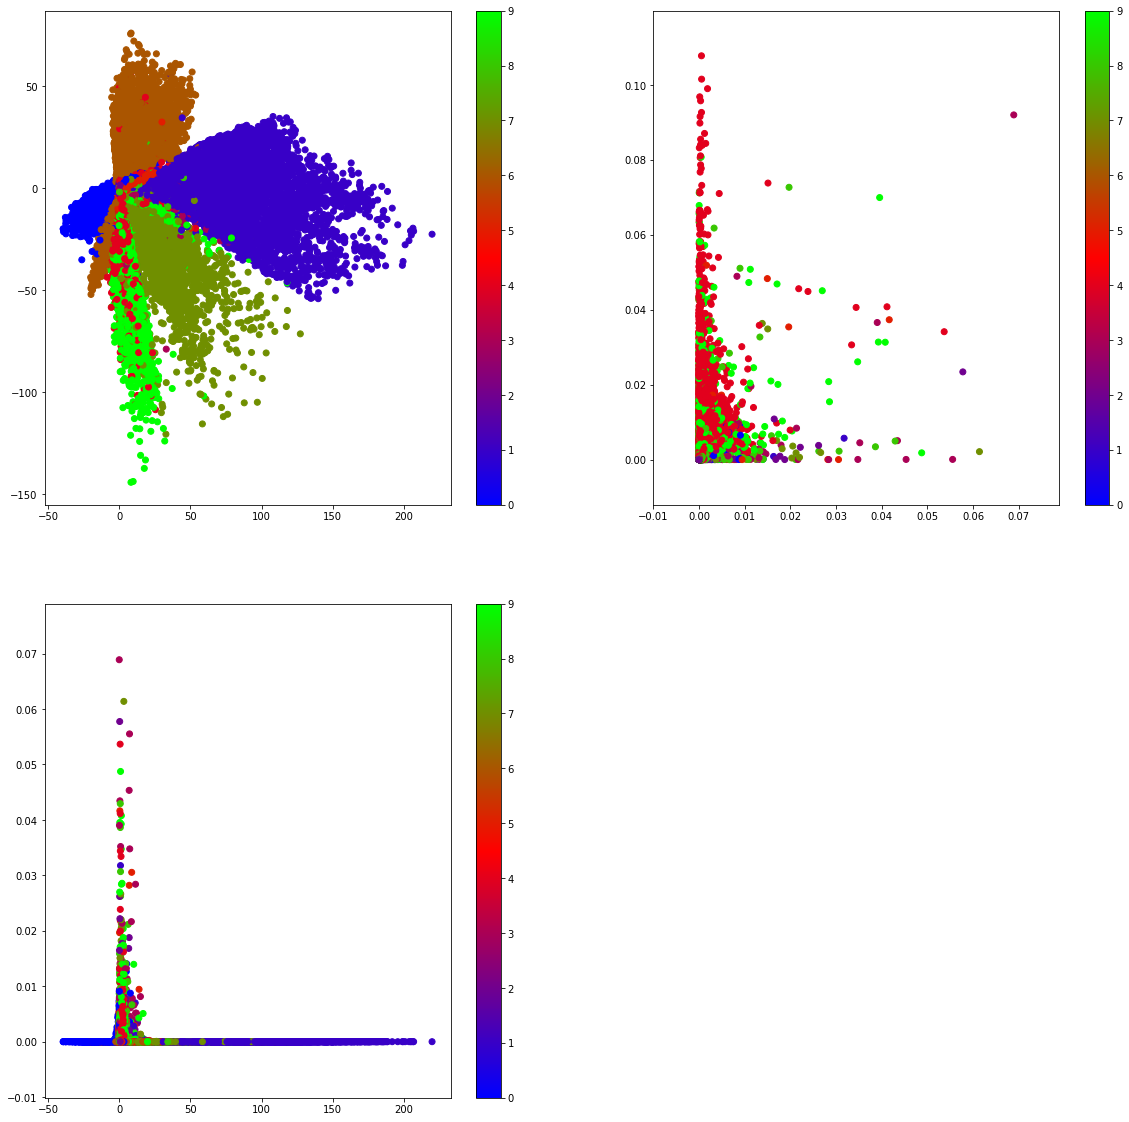

In [194]:
analyse_model_wrt_2d_plot(alpha=1, beta=0, gamma=0, epochs=10)

### Unsupervised VAE

In [245]:
log_folder = get_log_folder()
print('Starting autoencoder. Log folder={}'.format(log_folder))
model_unsupervised = VClassifier(
    x_dim=X_train.shape[1], 
    y_dim=0, 
    hidden_dims=[512, 256, 128, 2], 
    log_folder=log_folder,
    alpha=1,
    beta=1,
    gamma=0
)

model_unsupervised.fit(X_train, None, epochs=10)

# test_acc = model.calculate_accuracy(X=X_test, y=y_test)
# print("Test accuracy {}".format(test_acc))


Starting autoencoder. Log folder=/tmp/class_vae/deep/31_03_2019/20190331193109
Hidden shape: (?, 2)
xy.shape [None, 784]


/anaconda3/envs/cost-prediction-env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


n_batches: 984
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9


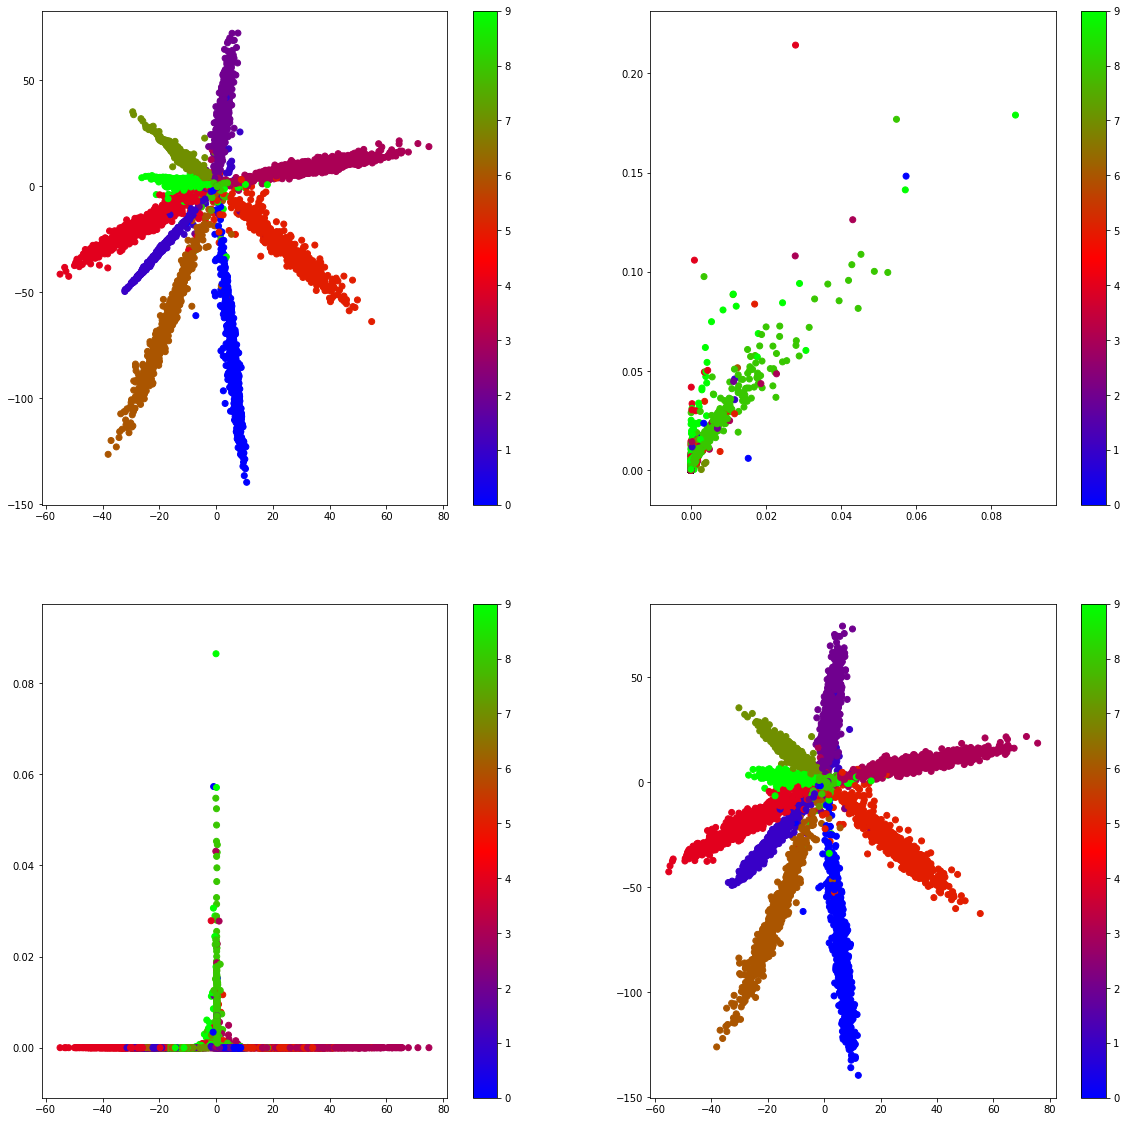

In [246]:
plot_2d_latent_space(model_unsupervised, onehot_encoder, X_test, y_test)

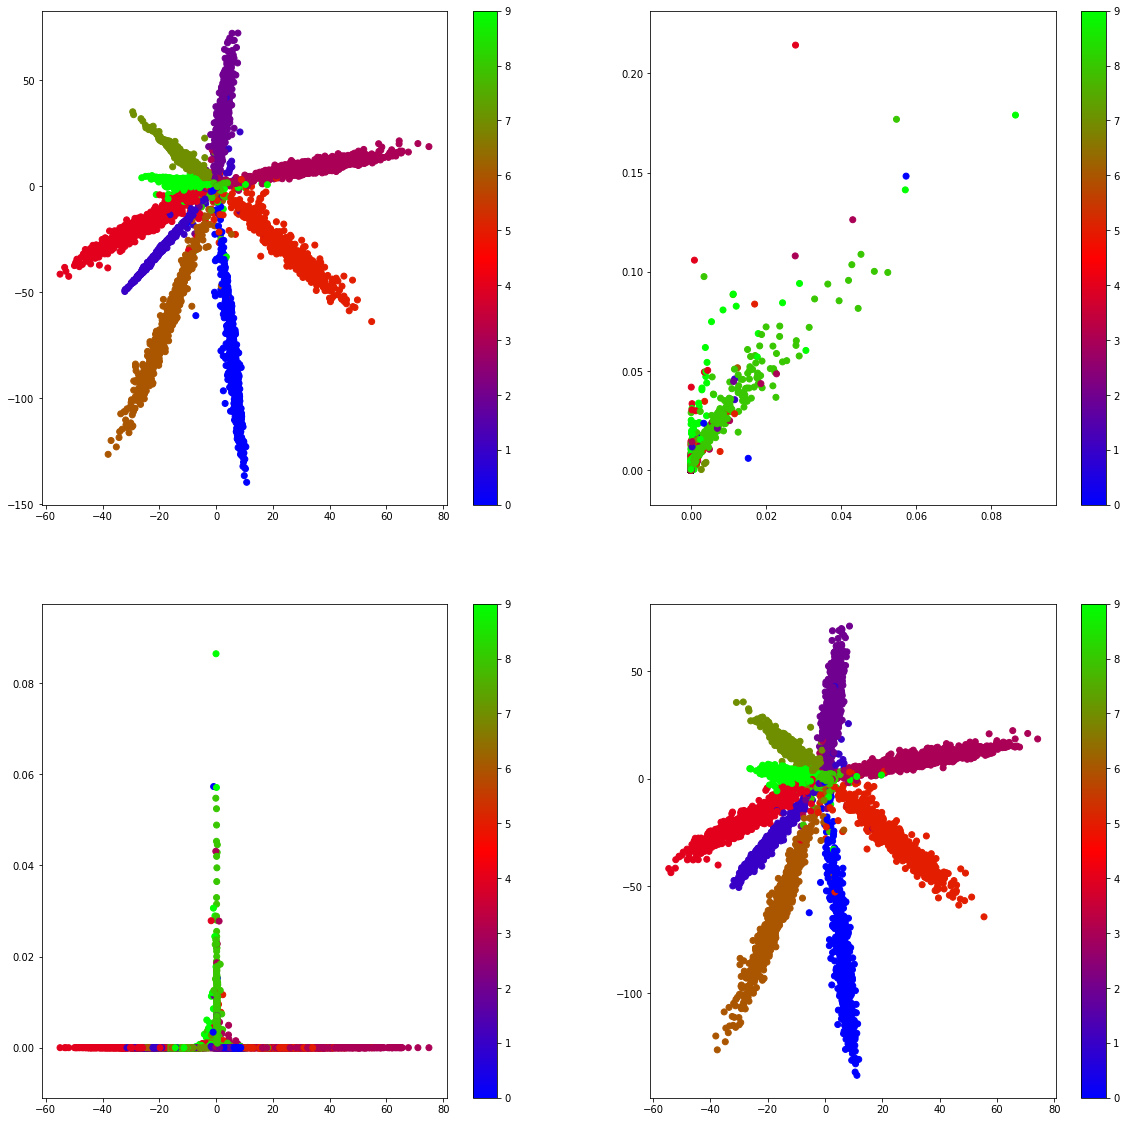

In [247]:
plot_2d_latent_space(model_unsupervised, onehot_encoder, X_train, y_train)

In [123]:
#plot_latent_space(model_unsupervised, onehot_encoder, X_test, y_test)

In [248]:
nx = ny = 20
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))
for i, yi in enumerate(x_values):
    for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*vae.batch_size)
        x_mean = vae_2d.generate(z_mu)
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0].reshape(28, 28)

plt.figure(figsize=(8, 10))        
Xi, Yi = np.meshgrid(x_values, y_values)
plt.imshow(canvas, origin="upper", cmap="gray")
plt.tight_layout()

NameError: name 'vae' is not defined